In [69]:
import pandas as pd
import time
import numpy as np

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
#pip install s3fs

In [ ]:
# Read the CSV file directly from S3
df_train_tr = pd.read_csv(f's3://creditcardfrauddataset/train_transaction.csv')
df_test_tr = pd.read_csv(f's3://creditcardfrauddataset/test_transaction.csv')

In [ ]:
import pyarrow as pa
import pyarrow.parquet as pq

# Convert the DataFrame to a PyArrow Table
train_table = pa.Table.from_pandas(df_train_tr)

# Define the path to save the Parquet file
parquet_path = f's3://creditcardfrauddataset/train_transaction.parquet'

# Use PyArrow to write the table to Parquet format directly to S3
pq.write_table(train_table, parquet_path)


In [ ]:
# Convert the DataFrame to a PyArrow Table
test_table = pa.Table.from_pandas(df_test_tr)

# Define the path to save the Parquet file
parquet_path = f's3://creditcardfrauddataset/test_transaction.parquet'

# Use PyArrow to write the table to Parquet format directly to S3
pq.write_table(test_table, parquet_path)

In [ ]:
df_train_tr = pd.read_parquet(f's3://creditcardfrauddataset/train_transaction.parquet')
df_test_tr = pd.read_parquet(f's3://creditcardfrauddataset/test_transaction.parquet')



In [ ]:
# Display the DataFrame
df_train_tr

In [ ]:
import pandas as pd
import numpy as np

def optimize_memory_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Initial memory usage: {:.2f} MB'.format(start_mem))

    for col in df.select_dtypes(include=['int', 'float']).columns:
        col_min = df[col].min()
        col_max = df[col].max()

        # Replace NaN and inf values with 0
        if pd.api.types.is_float_dtype(df[col]):
            df[col] = df[col].replace([np.inf, -np.inf], np.nan)  # Replace inf with NaN first
            df[col] = df[col].fillna(0)  # Then replace NaN with 0
            if all(df[col] == df[col].astype(int)):
                df[col] = df[col].astype(int)
            else:
                df[col] = pd.to_numeric(df[col], downcast='float')

        if pd.api.types.is_integer_dtype(df[col]):
            if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.int64)

    optimized_mem = df.memory_usage().sum() / 1024**2
    print('Optimized memory usage: {:.2f} MB'.format(optimized_mem))

    memory_diff = start_mem - optimized_mem
    print('Reduced memory by: {:.2f} MB'.format(memory_diff))

    return df


In [ ]:
import numpy as np
df_train_tr = optimize_memory_usage(df_train_tr)
df_test_tr = optimize_memory_usage(df_test_tr)

In [ ]:
df_train_tr

In [ ]:
df_train_tr.to_parquet('s3://creditcardfrauddataset/train_transaction_v1.parquet', engine='pyarrow', index=False)

In [ ]:
df_test_tr.to_parquet('s3://creditcardfrauddataset/test_transaction_v1.parquet', engine='pyarrow', index=False)

## import the memory optimized CSV files as dataframes

In [ ]:
df_train_tr = pd.read_parquet(f's3://creditcardfrauddataset/train_transaction_v1.parquet')
df_test_tr = pd.read_parquet(f's3://creditcardfrauddataset/test_transaction_v1.parquet')

**EDA**


In [ ]:

import matplotlib.pyplot as plt

value_counts = df_train_tr['isFraud'].value_counts().sort_index()

# Calculating percentages
total = value_counts.sum()
percentages = (value_counts / total * 100).round(2)  # Round to 2 decimal places

sum_transactions = df_train_tr.groupby('isFraud')['TransactionAmt'].sum()

# Calculating percentages for sums
total_sum = sum_transactions.sum()
percentages_sum = ((sum_transactions / total_sum) * 100).round(2)

# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the counts on the first subplot
axs[0].bar(value_counts.index, value_counts.values, color='skyblue')
axs[0].set_title('Fraud Transaction Distribution')
axs[0].set_xlabel('isFraud')
axs[0].set_ylabel('Transaction Count')

# Annotating the first subplot with percentages
for index, value in enumerate(value_counts.values):
    axs[0].text(index, value, f'{percentages[index]}%', ha='center', va='bottom')

# Setting xticks for the first subplot
axs[0].set_xticks(np.arange(len(value_counts.index)))
axs[0].set_xticklabels(value_counts.index)

# Plotting the sum of ColumnB on the second subplot
axs[1].bar(sum_transactions.index, sum_transactions.values, color='lightgreen')
axs[1].set_title('% of total amount in Transaction amount')
axs[1].set_xlabel('IsFraud')

# Annotating the second subplot with percentages
for index, value in enumerate(sum_transactions.values):
    axs[1].text(index, value, f'{percentages_sum[index]:.2f}%', ha='center', va='bottom')

# Setting xticks for the first subplot
axs[1].set_xticks(np.arange(len(value_counts.index)))
axs[1].set_xticklabels(value_counts.index)

plt.tight_layout()
# Display the plot
plt.show()

In [ ]:
import matplotlib.colors as mcolors

# Assuming df is your DataFrame
product_counts = df_train_tr['ProductCD'].value_counts().sort_index()
total = product_counts.sum()
percentages = (product_counts / total * 100).round(2)  # Calculate percentages and round to 2 decimal places

# Generate random colors
colors = np.random.rand(len(product_counts),3)

plt.figure(figsize=(10, 6))
bars = plt.bar(product_counts.index, product_counts.values, color=colors)

# Annotate each bar with percentage
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{percentage}%', ha='center', va='bottom')

plt.title('ProductCD Distribution(in %)')
plt.xlabel('ProductCD')
plt.ylabel('Percentage of Counts')
plt.xticks(rotation=0)  # Rotates X-axis labels for better readability
plt.show()

In [ ]:
product_fraud_counts = df_train_tr.groupby(['ProductCD', 'isFraud']).size().unstack(fill_value=0)

# Calculating fraud rate for each ProductCD
fraud_rate = product_fraud_counts[1] / (product_fraud_counts[0] + product_fraud_counts[1]) * 100  # in percentage

fig, ax1 = plt.subplots(figsize=(10, 6))

# Stacked bar chart for transaction counts
product_fraud_counts.plot(kind='bar', stacked=True, ax=ax1, color=['lightblue', 'salmon'])
ax1.set_title('Transaction Counts and Fraud Rate by ProductCD')
ax1.set_xlabel('ProductCD')
ax1.set_ylabel('Transaction Counts')
ax1.tick_params(axis='y')
ax1.set_xticklabels(product_fraud_counts.index, rotation=45)

# Line chart for fraud rate
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.plot(product_fraud_counts.index, fraud_rate, color='darkgreen', marker='o', label='Fraud Rate (%)')
ax2.set_ylabel('Fraud Rate (%)', color='darkgreen')
ax2.tick_params(axis='y', colors='darkgreen')
# Ensure the fraud rate is clearly visible by setting an appropriate limit
ax2.set_ylim(0, max(fraud_rate) + 10)

# Annotating line chart with fraud rate percentages
for i, txt in enumerate(fraud_rate):
    ax2.annotate(f'{txt:.2f}%', (product_fraud_counts.index[i], fraud_rate[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.colors as mcolors

# Assuming df is your DataFrame
card_counts = df_train_tr['card4'].value_counts().sort_index()
total = card_counts.sum()
percentages = (card_counts / total * 100).round(2)  # Calculate percentages and round to 2 decimal places

# Generate random colors
colors = np.random.rand(len(card_counts),3)

plt.figure(figsize=(10, 6))
bars = plt.bar(card_counts.index, card_counts.values, color=colors)

# Annotate each bar with percentage
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{percentage}%', ha='center', va='bottom')

plt.title('card4 distribution (in %)')
plt.xlabel('Card4')
plt.ylabel('Percentage of Counts')
plt.xticks(rotation=0)  # Rotates X-axis labels for better readability
plt.show()

In [ ]:
card4_fraud_counts = df_train_tr.groupby(['card4', 'isFraud']).size().unstack(fill_value=0)

# Calculating fraud rate for each card4
fraud_rate = card4_fraud_counts[1] / (card4_fraud_counts[0] + card4_fraud_counts[1]) * 100  # in percentage

fig, ax1 = plt.subplots(figsize=(10, 6))

# Stacked bar chart for transaction counts
card4_fraud_counts.plot(kind='bar', stacked=True, ax=ax1, color=['lightblue', 'salmon'])
ax1.set_title('Transaction Counts and Fraud Rate by Card Type')
ax1.set_xlabel('Card Type')
ax1.set_ylabel('Transaction Counts')
ax1.tick_params(axis='y')
ax1.set_xticklabels(card4_fraud_counts.index, rotation=45)

# Line chart for fraud rate
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.plot(card4_fraud_counts.index, fraud_rate, color='darkgreen', marker='o', label='Fraud Rate (%)')
ax2.set_ylabel('Fraud Rate (%)', color='darkgreen')
ax2.tick_params(axis='y', colors='darkgreen')
# Ensure the fraud rate is clearly visible by setting an appropriate limit
ax2.set_ylim(0, max(fraud_rate) +3)

# Annotating line chart with fraud rate percentages
for i, txt in enumerate(fraud_rate):
    ax2.annotate(f'{txt:.2f}%', (card4_fraud_counts.index[i], fraud_rate[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:

# Counting the occurrences of each unique value in 'P_emaildomain' and selecting the top 20
top_20_email_counts = df_train_tr['P_emaildomain'].value_counts().nlargest(20)

# Filtering the DataFrame to include only the top 20 email domains
top_20_emails = top_20_email_counts.index
filtered_df = df_train_tr[df_train_tr['P_emaildomain'].isin(top_20_emails)]

# Recalculating counts for the filtered DataFrame
email_counts = filtered_df['P_emaildomain'].value_counts().reindex(top_20_emails)
total_counts = email_counts.sum()

# Calculating percentage of total counts for each domain
email_percentages = (email_counts / total_counts * 100).round(2)

# Aggregating fraud counts by P_emaildomain for the filtered DataFrame
email_fraud_counts = filtered_df[filtered_df['isFraud'] == 1]['P_emaildomain'].value_counts().reindex(top_20_emails, fill_value=0)

# Calculating fraud rate for each of the top 20 P_emaildomain
fraud_rate = (email_fraud_counts / email_counts * 100).round(2)  # in percentage

# Creating the bar chart for top 20 email domain percentages
plt.figure(figsize=(14, 8))
bars = plt.bar(email_percentages.index, email_percentages.values, color='lightblue', label='Email Domain Percentages')

# Annotate bars with the percentage values
for bar, percentage in zip(bars, email_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage}%', ha='center', va='bottom')

# Setting x-labels to rotate for better readability
plt.xticks(rotation=45)

plt.xlabel('P_emaildomain')
plt.ylabel('Percentage of Total Counts')
plt.title('Percentage and Fraud Rate Percentage by P_emaildomain (Top 20)')

# Adding a secondary y-axis for the fraud rate percentages
ax2 = plt.gca().twinx()
line = ax2.plot(email_percentages.index, fraud_rate, color='darkgreen', marker='o', linestyle='-', linewidth=2, markersize=5, label='Fraud Rate (%)')
ax2.set_ylabel('Fraud Rate (%)', color='darkgreen')
ax2.tick_params(axis='y', colors='darkgreen')

# Annotate line chart with fraud rate percentages
for i, txt in enumerate(fraud_rate):
    ax2.annotate(f'{txt}%', (email_percentages.index[i], fraud_rate[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

EDA Inferences:
1. The target variable 'isFraud' is highly imbalanced, with 3.5% of transactions as fraud and 3.87% of transaction amounts as fraud. The average legitimate transaction Amount is 134.5 USD, and the fraud transaction Amount is 149.2 USD. Hence, fraudulent transactions occur
when the transaction amount is higher.
2. 74.5% of the transactions are for Product Code 'W' and 11.6% for Product Code 'C'. The fraud Transaction Rate is Maximum for Product Category 'C' and minimum for 'W'.
3. About 97% of transactions are from Mastercard (32%), and Visa (65%) and the fraud transaction rate is highest for Discover cards (7.72%).
4. About 38.78% of transactions are from Google and 17.43% from Yahoo Mail. The highest fraud % rate is from mail.com (18.96%), Microsoft (5.32%), Google (4.34%) and Yahoo
(2.25%).

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### **PCA**

In [70]:
df_train_tr = pd.read_parquet(f's3://creditcardfrauddataset/train_transaction_v1.parquet')
df_test_tr = pd.read_parquet(f's3://creditcardfrauddataset/test_transaction_v1.parquet')

In [8]:
df_train_tr.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0      0    150    discover    142  ...    0   0.0   0.0   0.0   0.0  0.0   
1    404    150  mastercard    102  ...    0   0.0   0.0   0.0   0.0  0.0   
2    490    150        visa    166  ...    0   0.0   0.0   0.0   0.0  0.0   
3    567    150  mastercard    117  ...    0   0.0   0.0   0.0   0.0  0.0   
4    514    150  mastercard    102  ...    0   0.0   0.0   0.0   0.0  0.0   

  V336  V337  V338  V339  
0  0.0   0.0   0.0   0.0  
1  0.0   0.0   0.0   0.0  
2  0.0   0.0   0.0   0.0  
3  0.0   0.0   0.0   0.0  
4  0.0   0.0   0.0   0.0  

[5 rows x 394 columns]

In [ ]:
cols_with_nan = df_train_tr.columns[df_train_tr.isna().any()].tolist()

# Print information about columns with NaN values
for col in cols_with_nan:
    num_nan = df_train_tr[col].isna().sum()  # Number of NaN values in the column
    col_dtype = df_train_tr[col].dtype  # Data type of the column
    print(f"Column: {col}, Number of NaNs: {num_nan}, Data Type: {col_dtype}")

In [71]:
df_train_tr = df_train_tr.dropna(subset=['card4', 'card6'], how='all')

In [5]:
df_train_tr

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400       68.500000         W   
1             2987001        0          86401       29.000000         W   
2             2987002        0          86469       59.000000         W   
3             2987003        0          86499       50.000000         W   
4             2987004        0          86506       50.000000         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047       49.000000         W   
590536        3577536        0       15811049       39.500000         W   
590537        3577537        0       15811079       30.950001         W   
590538        3577538        0       15811088      117.000000         W   
590539        3577539        0       15811131      279.950012         W   

        card1  card2  card3       card4  card5  ... V330  V331  V332  V333  \
0       13926      0    150    discover    142  ...    0   0.0   0.0   0.0   
1        2755    404    150  mastercard    102  ...    0   0.0   0.0   0.0   
2        4663    490    150        visa    166  ...    0   0.0   0.0   0.0   
3       18132    567    150  mastercard    117  ...    0   0.0   0.0   0.0   
4        4497    514    150  mastercard    102  ...    0   0.0   0.0   0.0   
...       ...    ...    ...         ...    ...  ...  ...   ...   ...   ...   
590535   6550      0    150        visa    226  ...    0   0.0   0.0   0.0   
590536  10444    225    150  mastercard    224  ...    0   0.0   0.0   0.0   
590537  12037    595    150  mastercard    224  ...    0   0.0   0.0   0.0   
590538   7826    481    150  mastercard    224  ...    0   0.0   0.0   0.0   
590539  15066    170    150  mastercard    102  ...    0   0.0   0.0   0.0   

        V334 V335 V336  V337  V338  V339  
0        0.0  0.0  0.0   0.0   0.0   0.0  
1        0.0  0.0  0.0   0.0   0.0   0.0  
2        0.0  0.0  0.0   0.0   0.0   0.0  
3        0.0  0.0  0.0   0.0   0.0   0.0  
4        0.0  0.0  0.0   0.0   0.0   0.0  
...      ...  ...  ...   ...   ...   ...  
590535   0.0  0.0  0.0   0.0   0.0   0.0  
590536   0.0  0.0  0.0   0.0   0.0   0.0  
590537   0.0  0.0  0.0   0.0   0.0   0.0  
590538   0.0  0.0  0.0   0.0   0.0   0.0  
590539   0.0  0.0  0.0   0.0   0.0   0.0  

[588975 rows x 394 columns]

# PCA

In [72]:
#label encoding of categorical columns
df_train_tr = pd.get_dummies(df_train_tr) 

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
# Applying OneHotEncoding using pandas.get_dummies
df_train_tr_en = pd.get_dummies(df_train_tr)

# Standardizing the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_train_tr_en)

# Applying PCA
pca = PCA()
principal_components = pca.fit_transform(scaled_features)

# Creating a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components)

pca_df

In [ ]:
# Explained variance ratio
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

# Cumulative explained variance
import numpy as np
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("\nCumulative Explained Variance:")
print(cumulative_variance)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(14, 5))

# Plotting the explained variance ratio
plt.subplot(1, 2, 1)
plt.plot(explained_variance_ratio, marker='o')
plt.title('Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')

# Plotting the cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.axhline(y=0.85, color='r', linestyle='--')  # 85% threshold line

plt.tight_layout()
plt.show()


In [ ]:

# Find the number of components needed to explain at least 85% of the variance
n_components_85 = np.where(cumulative_variance >= 0.85)[0][0] + 1  # +1 because indexing starts at 0

print(f"Number of components to explain at least 85% variance: {n_components_85}")

## Model Evaluation

In [73]:
# Features and target variable
X = df_train_tr.drop('isFraud', axis=1)  # all columns except the target
y = df_train_tr['isFraud']  # the target column

In [12]:
import sys
!{sys.executable} -m pip install imbalanced-learn


In [74]:
#Data split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Data preprocessing
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=126)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier  # Example classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming X_train and y_train are your features and labels respectively

# Initialize PCA with 126 components
pca = PCA(n_components=126)

# Create a pipeline with PCA and a classifier
model_pipeline = Pipeline([
    ('pca', pca),
    ('classifier', RandomForestClassifier())
])
print('Start model fitting')
# Fit the model
model_pipeline.fit(X_train, y_train)

# Now, you can use model_pipeline to predict, score, etc.
y_pred = model_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))



# Check if it is a binary classification problem
if len(np.unique(y_test)) == 2:
    y_prob = model_pipeline.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()



In [9]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install lightgbm


In [10]:
import sys
!{sys.executable} -m pip install xgboost


In [75]:
import joblib  # Import joblib for model serialization
from io import BytesIO
import boto3
from joblib import dump
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, recall_score, f1_score, make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


## Decision Tree and Logistic regression model Training

In [38]:

# Define your models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

# Prepare parameter grids
param_grids = {
    "Decision Tree": {'classifier__max_depth': [None, 10, 20]},
    "Logistic Regression": {'classifier__C': [0.1, 1, 10]},
    "Random Forest": {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [8, 10, 20],
        'classifier__learning_rate': [0.05, 0.1]
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [8, 10, 20],
        'classifier__num_leaves': [128, 256],
        'classifier__learning_rate': [0.05, 0.1]
    }
}

# Scoring setup
scoring = {
    'AUC': 'roc_auc',
    'Accuracy': 'accuracy',
    'Recall': make_scorer(recall_score, average='macro'),
    'F1': make_scorer(f1_score, average='macro')
}

# AWS S3 setup
s3_client = boto3.client('s3')
bucket_name = 'creditcardfrauddataset'  # Ensure this is the correct bucket name without the 's3://' prefix


In [ ]:
# Initialize and run pipelines
results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('classifier', model)
    ])
    print(f'Starting training model: {name}')
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=2, scoring=scoring, refit='AUC',n_jobs=3)
    grid_search.fit(X_train_resampled, y_train_resampled)
    print('GridSearch Complete')

    # Save model to S3
    best_model = grid_search.best_estimator_
    buffer = BytesIO()
    dump(best_model, buffer)
    buffer.seek(0)
    model_key = f"models/{name}_best_model.joblib"
    s3_client.upload_fileobj(buffer, bucket_name, model_key)
    buffer.close()
    print('Model Save Complete')
    # Model evaluation
    y_pred = best_model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cv_scores = cross_val_score(best_model, X_test_scaled, y_test, cv=5)

    # Store and print results
    results[name] = {
        "s3_model_path": f's3://{bucket_name}/{model_key}',
        "accuracy": accuracy,
        "classification_report": report,
        "cross_validation_mean_accuracy": cv_scores.mean(),
        "cross_validation_std": cv_scores.std()
    }
    
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)
    print(f"Cross-Validation Mean Accuracy: {cv_scores.mean():.2f}")
    print(f"Cross-Validation Std: {cv_scores.std():.2f}")
    print("-" * 30)


Starting training model: Decision Tree
GridSearch Complete
Model Save Complete
Model: Decision Tree
Accuracy: 0.92
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95    170504
           1       0.22      0.56      0.31      6189

    accuracy                           0.92    176693
   macro avg       0.60      0.74      0.63    176693
weighted avg       0.96      0.92      0.93    176693

Cross-Validation Mean Accuracy: 0.96
Cross-Validation Std: 0.00
------------------------------
Starting training model: Logistic Regression
GridSearch Complete
Model Save Complete
Model: Logistic Regression
Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88    170504
           1       0.11      0.74      0.19      6189

    accuracy                           0.79    176693
   macro avg       0.55      0.76      0.54    176693
weighted avg      

## XGBoost and LightGBM Training

In [ ]:

# Calculate the scale_pos_weight for XGBoost
scale_pos_weight = np.sqrt((len(y) - np.sum(y)) / np.sum(y))

# Define your models
models = {
    'XGBoost': XGBClassifier(scale_pos_weight=scale_pos_weight),
    'LightGBM': LGBMClassifier(is_unbalance=True)
}

# Prepare parameter grids
param_grids = {
    'XGBoost': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [8, 10, 20],
        'classifier__learning_rate': [0.05, 0.1]
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [8, 10, 20],
        'classifier__num_leaves': [128, 256],
        'classifier__learning_rate': [0.05, 0.1]
    }
}

# Scoring setup
scoring = {
    'AUC': 'roc_auc',
    'Accuracy': 'accuracy',
    'Recall': make_scorer(recall_score, average='macro'),
    'F1': make_scorer(f1_score, average='macro')
}


# Initialize and run pipelines
results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('classifier', model)
    ])
    print(f'Starting training model: {name}')
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring=scoring, refit='AUC', n_jobs=1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    print('GridSearch Complete')

    # Save model to S3
    best_model = grid_search.best_estimator_
    buffer = BytesIO()
    dump(best_model, buffer)
    buffer.seek(0)
    model_key = f"models/{name}_best_model.joblib"
    s3_client.upload_fileobj(buffer, bucket_name, model_key)
    buffer.close()
    print('Model Save Complete')

    # Model evaluation
    y_pred = best_model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cv_scores = cross_val_score(best_model, X_test_pca, y_test, cv=5)

    # Store and print results
    results[name] = {
        "s3_model_path": f's3://{bucket_name}/{model_key}',
        "accuracy": accuracy,
        "classification_report": report,
        "cross_validation_mean_accuracy": cv_scores.mean(),
        "cross_validation_std": cv_scores.std()
    }

    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)
    print(f"Cross-Validation Mean Accuracy: {cv_scores.mean():.2f}")
    print(f"Cross-Validation Std: {cv_scores.std():.2f}")
    print("-" * 30)


## Random Forest Moel Training

In [ ]:
# Define your models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
}

# Prepare parameter grids specifically for RandomizedSearchCV
param_distributions = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20]
}


In [36]:
%%time
from joblib import dump

# Run pipeline with RandomizedSearchCV
results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('classifier', model)
    ])
    print(f'Starting training model: {name}')
    random_search = RandomizedSearchCV(pipeline, param_distributions=param_distributions, n_iter=5, cv=2, scoring=scoring, refit='AUC', n_jobs=13)
    random_search.fit(X_train_resampled, y_train_resampled)
    print('Randomized Search Complete')

    best_model = random_search.best_estimator_
    
    # Define the path for saving the model
    model_directory = 'model/'
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)

    model_filename = f"{name}_best_model.joblib"
    model_path = os.path.join(model_directory, model_filename)

    # Save the model locally
    dump(best_model, model_path)

    print(f"Model saved locally at: {model_path}")

    y_pred = best_model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cv_scores = cross_val_score(best_model, X_test_pca, y_test, cv=2)

    results[name] = {
        "s3_model_path": f's3://{bucket_name}/{model_key}',
        "accuracy": accuracy,
        "classification_report": report,
        "cross_validation_mean_accuracy": cv_scores.mean(),
        "cross_validation_std": cv_scores.std()
    }

    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)
    print(f"Cross-Validation Mean Accuracy: {cv_scores.mean():.2f}")
    print(f"Cross-Validation Std: {cv_scores.std():.2f}")
    print("-" * 30)

Starting training model: Random Forest


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Randomized Search Complete
Model saved locally at: model/Random Forest_best_model.joblib
Model: Random Forest
Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    170504
           1       0.17      0.70      0.28      6189

    accuracy                           0.87    176693
   macro avg       0.58      0.79      0.60    176693
weighted avg       0.96      0.87      0.91    176693

Cross-Validation Mean Accuracy: 0.97
Cross-Validation Std: 0.00
------------------------------
CPU times: user 18min 7s, sys: 1.25 s, total: 18min 8s
Wall time: 26min 3s


## Model Evaluation

Processing model: Decision Tree_best_model

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95    170504
           1       0.22      0.56      0.31      6189

    accuracy                           0.92    176693
   macro avg       0.60      0.74      0.63    176693
weighted avg       0.96      0.92      0.93    176693



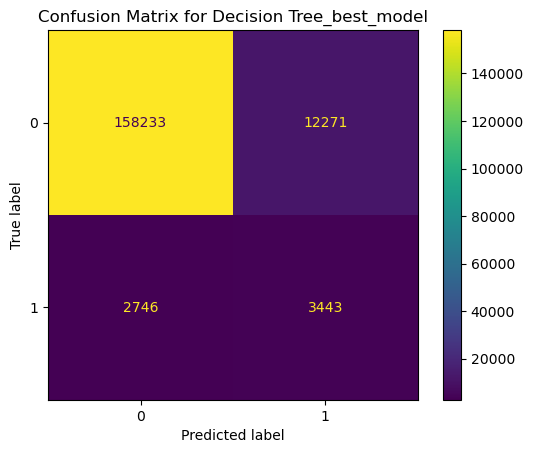

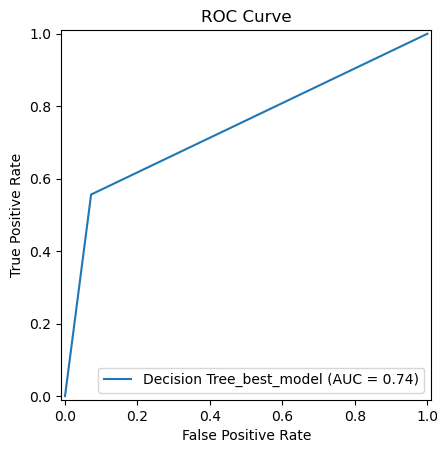

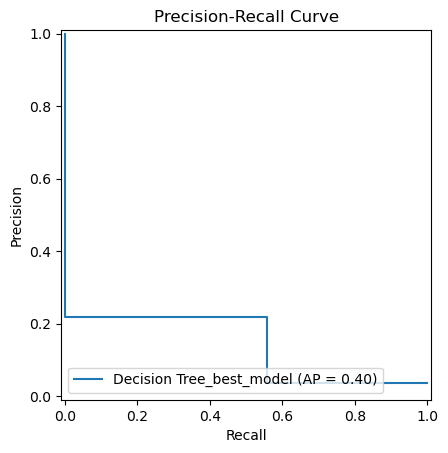

Processing model: LightGBM_best_model

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97    170504
           1       0.32      0.72      0.44      6189

    accuracy                           0.94    176693
   macro avg       0.65      0.83      0.70    176693
weighted avg       0.97      0.94      0.95    176693



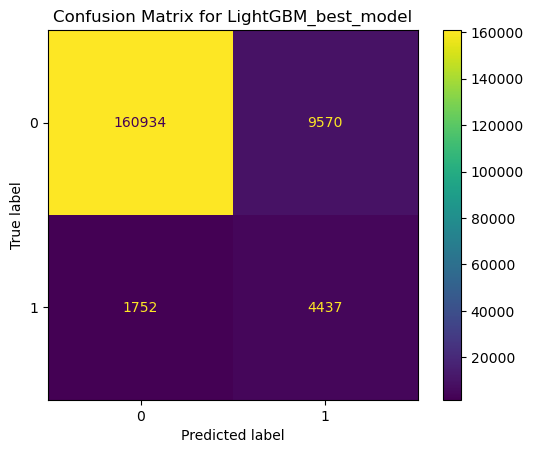

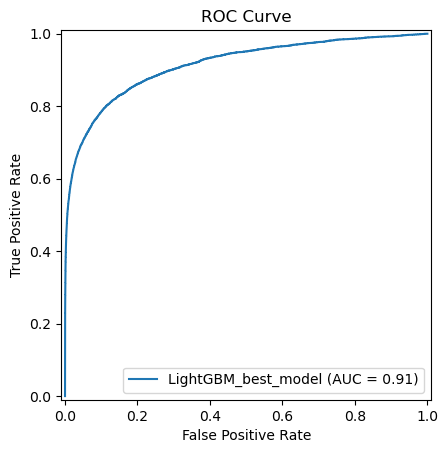

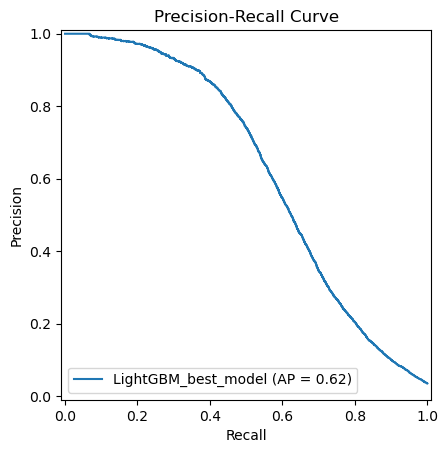

Processing model: Logistic Regression_best_model

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.67      0.80    170504
           1       0.08      0.83      0.15      6189

    accuracy                           0.68    176693
   macro avg       0.54      0.75      0.48    176693
weighted avg       0.96      0.68      0.78    176693



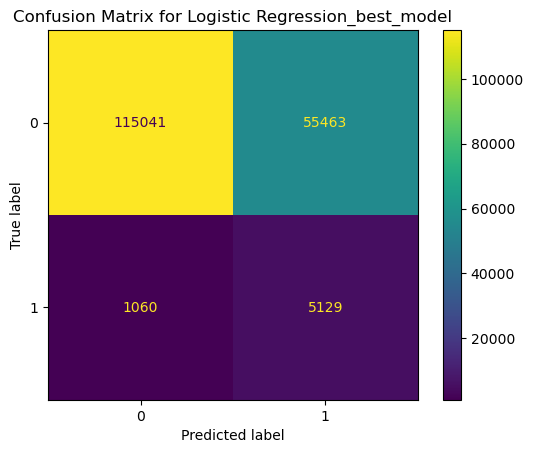

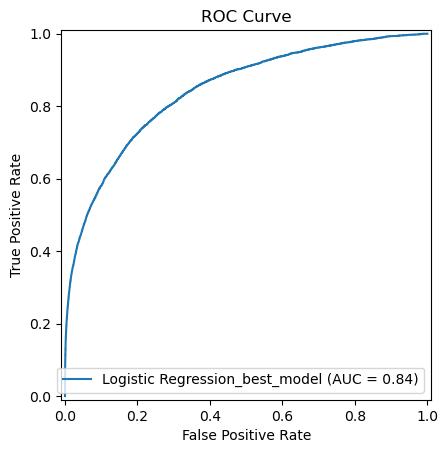

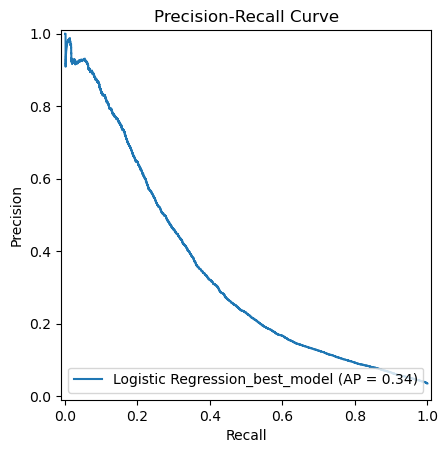

Processing model: Random Forest_best_model

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.73      0.84    170504
           1       0.10      0.84      0.18      6189

    accuracy                           0.73    176693
   macro avg       0.55      0.78      0.51    176693
weighted avg       0.96      0.73      0.82    176693



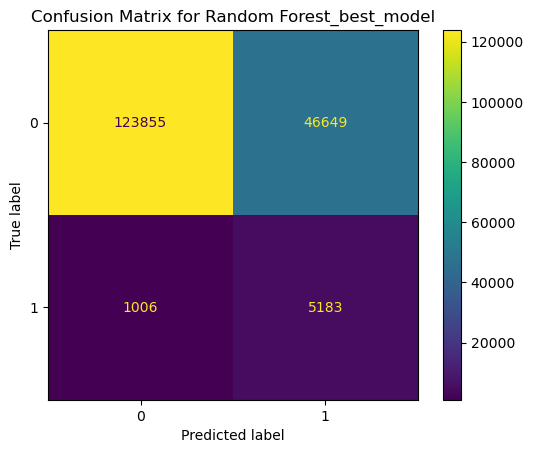

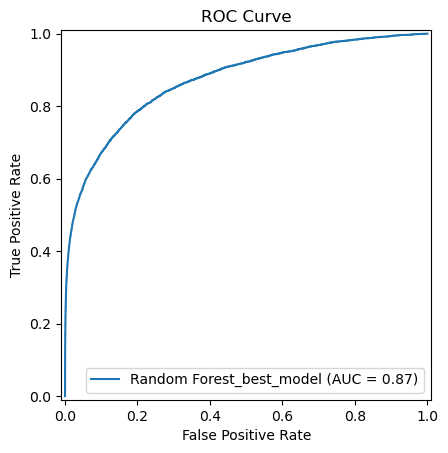

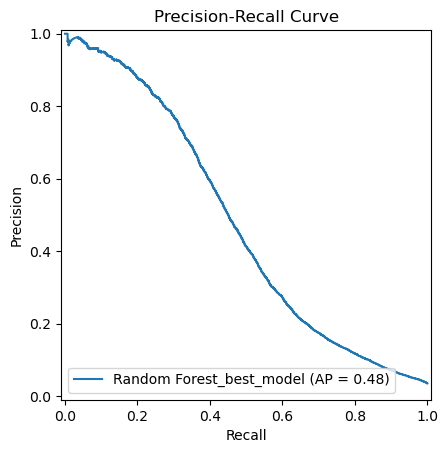

Processing model: XGBoost_best_model

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    170504
           1       0.51      0.65      0.57      6189

    accuracy                           0.97    176693
   macro avg       0.75      0.82      0.78    176693
weighted avg       0.97      0.97      0.97    176693



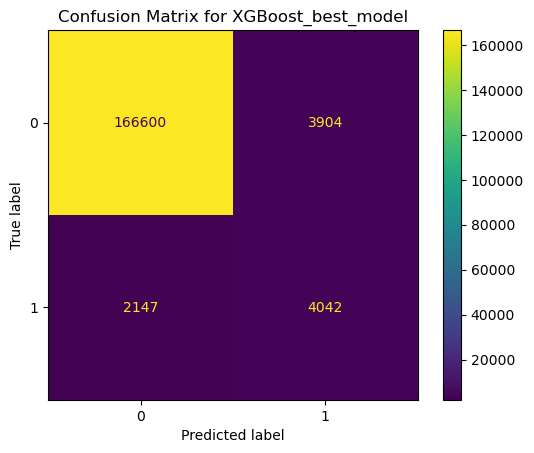

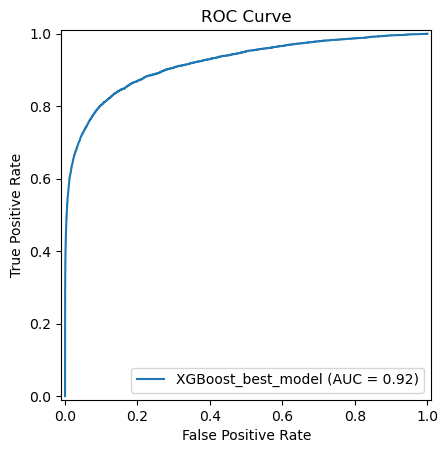

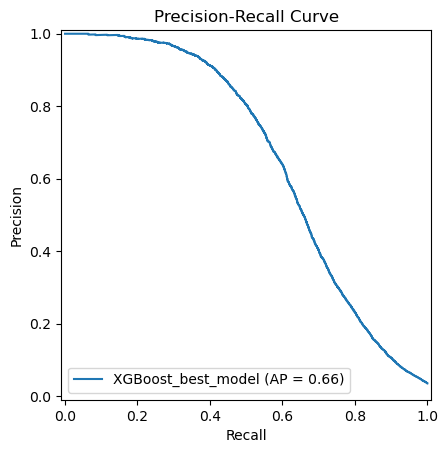

In [37]:
import boto3
import joblib
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

# AWS S3 Setup
s3_client = boto3.client('s3')
bucket_name = 'creditcardfrauddataset'  
prefix = 'models/'  

# Retrieve model list from S3 bucket
response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

def load_model_from_s3(key):
    response = s3_client.get_object(Bucket=bucket_name, Key=key)
    model_file = BytesIO(response['Body'].read())
    model = joblib.load(model_file)
    return model

def plot_model_performance(model, X_test, y_test, model_name):
    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    # Define a new threshold
    threshold = 0.4  # Lower than default 0.5 to reduce false negatives

    # Apply threshold to positive class probabilities to create new predictions
    y_pred_new_threshold = (y_prob >= threshold).astype(int)


    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred_new_threshold)
    report = classification_report(y_test, y_pred_new_threshold)

    print("\nClassification Report:")
    print(report)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot()
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name).plot()
    plt.title('ROC Curve')
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=pr_auc, estimator_name=model_name).plot()
    plt.title('Precision-Recall Curve')
    plt.show()

# Main loop to process each model
if 'Contents' in response:
    for item in response['Contents']:
        key = item['Key']
        if key.endswith('.joblib'):  # Ensure it's a model file
            model_name = key.split('/')[-1].replace('.joblib', '')
            print(f"Processing model: {model_name}")
            model = load_model_from_s3(key)
            plot_model_performance(model, X_test_pca, y_test, model_name)


# Explainable AI demonstration

In [76]:
import boto3
import joblib
from io import BytesIO

# Set up the connection to S3
s3 = boto3.client('s3')
bucket_name = 'creditcardfrauddataset'  # Replace with your bucket name
key = 'models/XGBoost_best_model.joblib'

# Download the model from S3
response = s3.get_object(Bucket=bucket_name, Key=key)
model_content = response['Body'].read()

# Load the model from the byte stream
model_buffer = BytesIO(model_content)
pipeline = joblib.load(model_buffer)

# Assuming 'classifier' is the step name for the XGBoost model in your pipeline
model = pipeline.named_steps['classifier']


In [77]:

model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## SHAP

In [ ]:
import shap

# Create the SHAP Explainer directly with the model
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_train_scaled)  # Use the scaled data without PCA

# It's good practice to check the output
print(shap_values.shape)  # This helps to understand the output format


In [56]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

In [ ]:
import pandas as pd

# Assuming 'X' is your original DataFrame and 'X_train_scaled' is its scaled numpy array version
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

shap_values = explainer.shap_values(X_train_scaled_df)


# Global SHAP Summary Plot
shap.summary_plot(shap_values, X_train_scaled_df, feature_names=X_train_scaled_df.columns.tolist())


In [15]:
# Single prediction SHAP Force Plot
shap.force_plot(explainer.expected_value, shap_values[0], X_train_scaled_df.iloc[0], feature_names=X_train_scaled_df.columns.tolist())


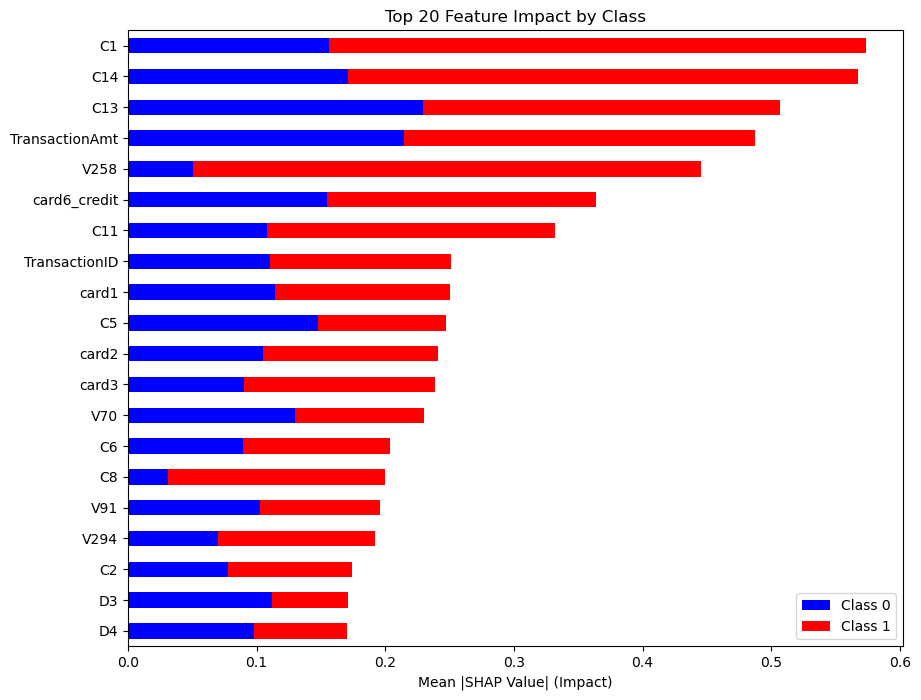

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'shap_values' are computed and 'X_train_scaled_df' is your feature DataFrame
# 'target' should be your binary target array aligned with your X_train_scaled_df

# Calculate mean absolute SHAP values for each feature separated by class
features = X_train_scaled_df.columns.tolist()
class_0_shap = np.mean(np.abs(shap_values[target == 0]), axis=0)
class_1_shap = np.mean(np.abs(shap_values[target == 1]), axis=0)

# Create a DataFrame to make plotting easier
shap_df = pd.DataFrame({
    'Feature': features,
    'Class 0': class_0_shap,
    'Class 1': class_1_shap
})

# Sort by total impact and select the top 20 features
shap_df['Total'] = shap_df['Class 0'] + shap_df['Class 1']
shap_df = shap_df.sort_values(by='Total', ascending=False).head(20)

# Plotting the top 20 features
fig, ax = plt.subplots(figsize=(10, 8))
shap_df[['Class 0', 'Class 1']].plot(kind='barh', stacked=True, ax=ax, color=['blue', 'red'])
ax.set_yticklabels(shap_df['Feature'])
ax.set_xlabel('Mean |SHAP Value| (Impact)')
ax.set_title('Top 20 Feature Impact by Class')
plt.gca().invert_yaxis()  # To show the largest bar at the top
plt.show()


## LIME (Local Interpretable Model-agnostic Explanations)



In [31]:
pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 136.5 MB/s eta 0:00:0000:0100:01
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=6490c1d3ea60251811c6a54cc44b01928a442a04b3f4db670f72cf3b868ccb31
  Stored in directory: /home/ec2-user/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mkl-fft 1.3.10 requires mkl, which is not installed.
hdijupyterutils 0.21.0 requires pandas<

In [ ]:
import lime
import lime.lime_tabular

# Initialize the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled_df),
    feature_names=X_train_scaled_df.columns,
    class_names=['Non-Fraud', 'Fraud'],  # Adjust based on your target classes
    mode='classification'
)



In [35]:
# LIME PLOT
# Select an instance to explain
idx = 1  # Index of the instance in X_test dataframe
data_instance = X_test_scaled_df.iloc[idx].values.reshape(1, -1)

# Generate the LIME explanation
exp = explainer.explain_instance(
    data_row=data_instance.flatten(),
    predict_fn=model.predict_proba  # Ensure your model has a predict_proba method
)

# Visualize the explanation
exp.show_in_notebook(show_table=True, show_all=False)

In [38]:
#Lime Local Explanation Plot

# Select an instance to explain
index_to_explain = 1  # For example, explaining the second instance in the test set
data_instance = X_test_scaled_df.iloc[index_to_explain].values

# Generate the explanation for the selected instance
exp = explainer.explain_instance(
    data_row=data_instance,
    predict_fn=model.predict_proba,  # Your model's prediction method
    num_features=20  # Number of features to include in the explanation
)

# Visualize the explanation
exp.show_in_notebook(show_table=True, show_all=False)


## Partial Dependance Plot

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/inspection/_plot/partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/inspection/_plot/partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


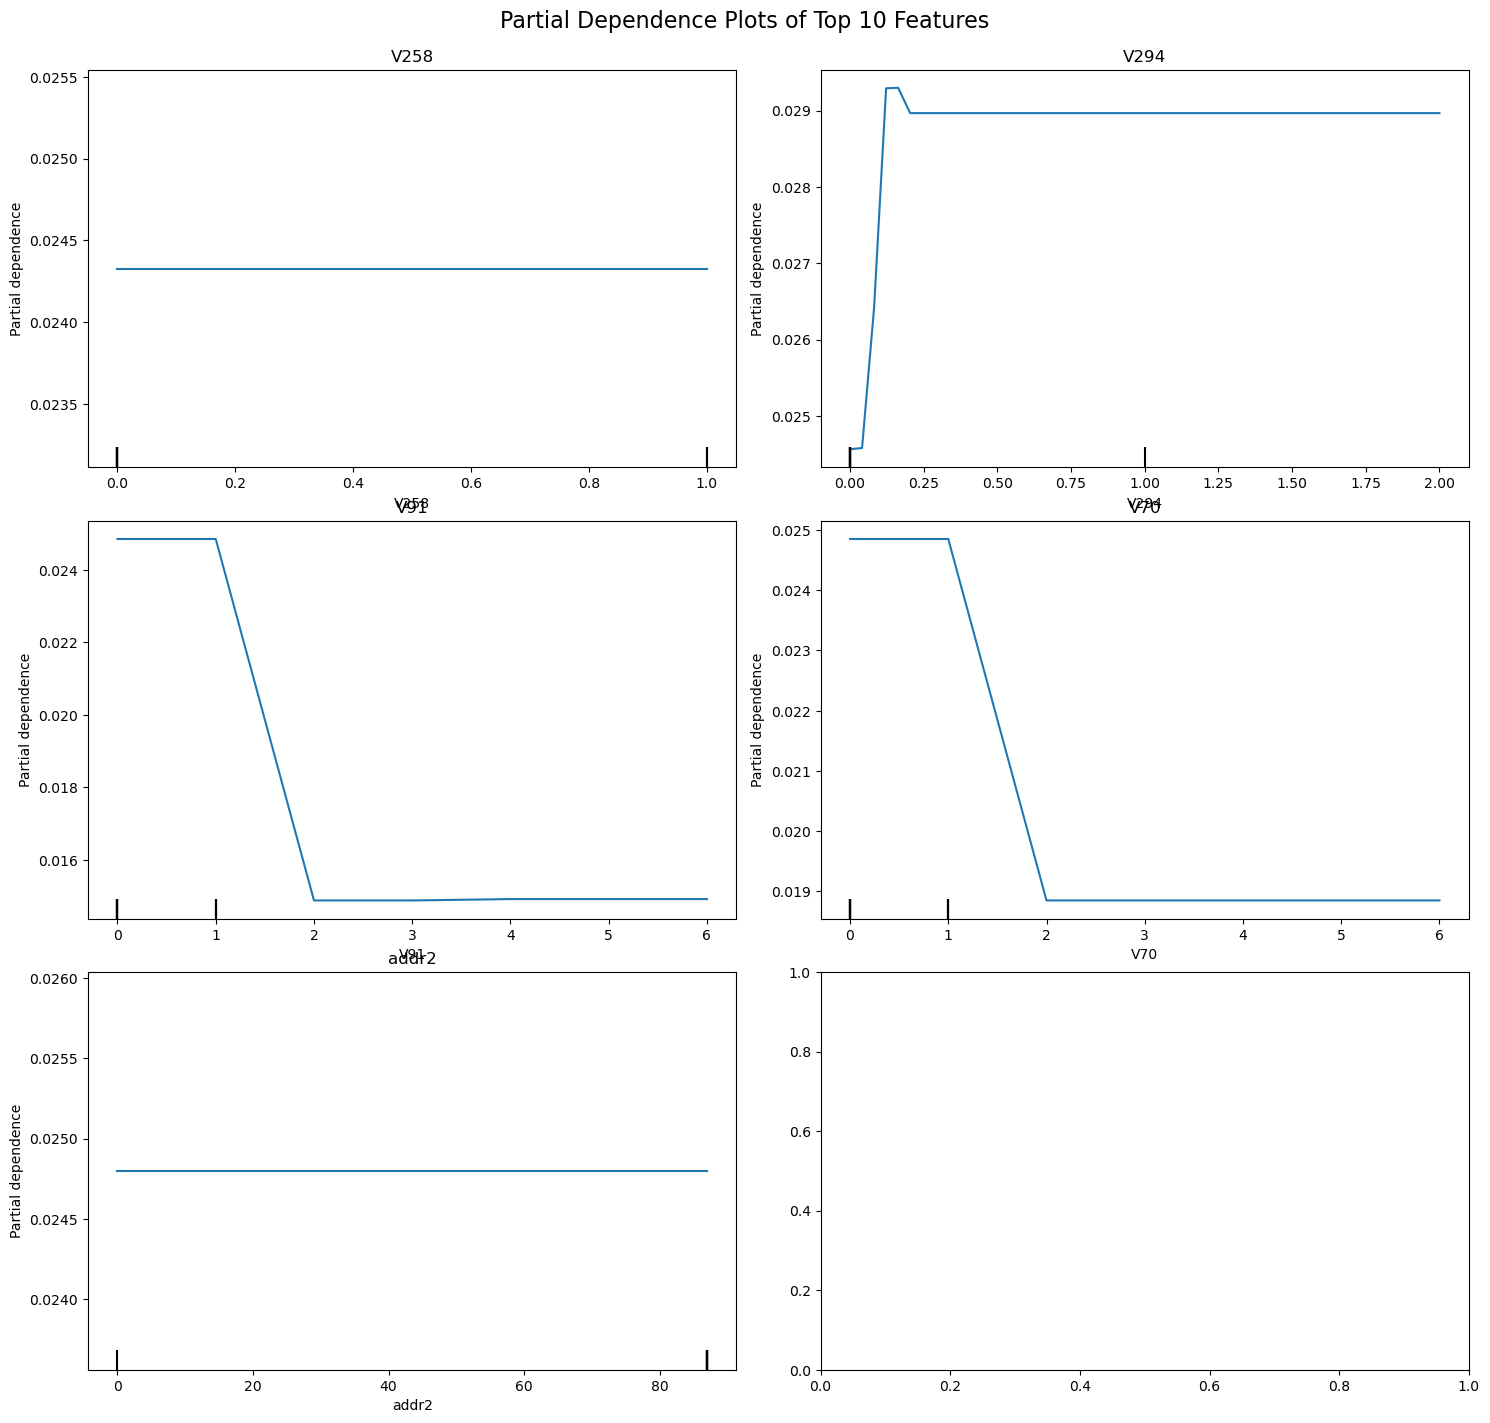

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestClassifier  # Assuming model

# Let's assume `model` is your trained RandomForestClassifier and `X_train` is your training data

# Get feature importances and corresponding feature names
feature_importances = model.feature_importances_
features = X_train.columns

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]
top_features = features[sorted_idx[:5]]  # Select top 10 features

# Generate and plot partial dependence plots for the top features
fig, axs = plt.subplots(3, 2, figsize=(15, 20))  # 10 plots in a 5x2 grid
axs = axs.ravel()

for i, feature in enumerate(top_features):
    PartialDependenceDisplay.from_estimator(
        model,
        X_train,
        features=[feature],
        kind="average",  # 'average' for average effects, 'individual' for ICE curves
        ax=axs[i],
        grid_resolution=50
    )
    axs[i].set_title(feature)  # Set title to feature name

plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.5)
plt.suptitle("Partial Dependence Plots of Top 10 Features", fontsize=16)
plt.show()
